# Multimodal Emotion Recognition using TESS Dataset

This project implements:
1. Speech-only Emotion Recognition
2. Text-only Emotion Recognition
3. Multimodal Fusion Model

Dataset: Toronto Emotional Speech Set (TESS)


In [1]:
!ls /kaggle/input


datasets


In [2]:
tess_path = "/kaggle/input/datasets/ejlok1/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data"

In [3]:
import os

print(os.listdir(tess_path)[:10])


['YAF_fear', 'OAF_angry', 'OAF_Fear', 'OAF_disgust', 'OAF_neutral', 'YAF_angry', 'OAF_Sad', 'YAF_disgust', 'YAF_neutral', 'OAF_Pleasant_surprise']


In [4]:
import os

sample_folder = os.path.join(tess_path, "OAF_angry")

print(os.listdir(sample_folder)[:5])


['OAF_raid_angry.wav', 'OAF_half_angry.wav', 'OAF_bought_angry.wav', 'OAF_rose_angry.wav', 'OAF_numb_angry.wav']


In [5]:

# Import 


!pip install librosa nltk

import os
import numpy as np
import librosa
import nltk

nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Dropout, LSTM, Bidirectional,
    Embedding, Input, Concatenate
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2026-02-13 09:48:32.201285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770976112.356038      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770976112.401373      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770976112.774951      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770976112.774990      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the

**Feature extraction**

In [6]:
# ===============================
# MFCC EXTRACTION


def extract_mfcc(path, max_len=100):

    audio, sr = librosa.load(path, sr=22050)

    mfcc = librosa.feature.mfcc(
        y=audio, sr=sr, n_mfcc=40
    )

    if mfcc.shape[1] < max_len:

        mfcc = np.pad(
            mfcc,
            ((0,0),(0,max_len-mfcc.shape[1])),
            mode="constant"
        )

    else:
        mfcc = mfcc[:,:max_len]

    return mfcc


**LOAD DATA**

In [8]:

# LOAD DATA

speech_data = []
labels = []
texts = []   

for root, dirs, files in os.walk(tess_path):

    for file in files:

        if file.endswith(".wav"):

            emotion = file.split("_")[2]


            path = os.path.join(root, file)

            mfcc = extract_mfcc(path)

            speech_data.append(mfcc)
            labels.append(emotion)

            # Generate text
            sentence = f"This is a {emotion} speech sample"
            texts.append(sentence)


print("Total Samples:", len(speech_data))


Total Samples: 2800


**DATA PREPARATION**

In [9]:

# DATA PREPARATION

X_speech = np.array(speech_data)
y = np.array(labels)

le = LabelEncoder()
y_enc = le.fit_transform(y)

# Reshape for LSTM
X_speech = X_speech.transpose(0,2,1)

# Train-Test Split
X_train_s, X_test_s, y_train, y_test, texts_train, texts_test = train_test_split(
    X_speech, y_enc, texts,
    test_size=0.2,
    stratify=y_enc,
    random_state=42
)


# SPEECH MODEL

In [10]:

# SPEECH MODEL


speech_model = Sequential([

    Bidirectional(
        LSTM(64),
        input_shape=(100,40)
    ),

    Dropout(0.3),

    Dense(64, activation="relu"),

    Dense(len(np.unique(y_enc)), activation="softmax")

])


speech_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


speech_model.summary()


I0000 00:00:1770976251.864024      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770976251.870165      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        53,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,471 (244.03 KB)

 Trainable params: 62,471 (244.03 KB)

 Non-trainable params: 0 (0.00 B)

**MODEL TRAINING**

In [11]:
speech_model.fit(
    X_train_s, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

speech_model.save("speech_model.h5")


Epoch 1/30


I0000 00:00:1770976255.633583     147 cuda_dnn.cc:529] Loaded cuDNN version 91002


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.2928 - loss: 1.7634 - val_accuracy: 0.6250 - val_loss: 0.9059
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6543 - loss: 0.8328 - val_accuracy: 0.8304 - val_loss: 0.5073
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8412 - loss: 0.4403 - val_accuracy: 0.9509 - val_loss: 0.2442
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9200 - loss: 0.2695 - val_accuracy: 0.9554 - val_loss: 0.2033
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9576 - loss: 0.1816 - val_accuracy: 0.9688 - val_loss: 0.1167
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9610 - loss: 0.1238 - val_accuracy: 0.9732 - val_loss: 0.1068
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9736 - loss: 0.1011 - val_accuracy: 0.9688 - val_loss: 0.0965
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9833 - loss: 0.0712 - val_accuracy: 0.9777 - val_loss: 0.








# TEXT EMOTION MODEL




In [12]:

# TEXT TOKENIZATION

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)

tokenizer.fit_on_texts(texts_train)

seq_train = tokenizer.texts_to_sequences(texts_train)
seq_test = tokenizer.texts_to_sequences(texts_test)

X_train_t = pad_sequences(seq_train, maxlen=20)
X_test_t = pad_sequences(seq_test, maxlen=20)

print("Text train shape:", X_train_t.shape)
print("Text test shape:", X_test_t.shape)


Text train shape: (2240, 20)
Text test shape: (560, 20)


In [13]:

# TEXT MODEL


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout

text_model = Sequential([

    Embedding(5000, 128, input_length=20),

    Bidirectional(LSTM(64)),

    Dropout(0.3),

    Dense(64, activation="relu"),

    Dense(len(np.unique(y_enc)), activation="softmax")

])


text_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


text_model.build(input_shape=(None, 20))
text_model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 128)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 747,527 (2.85 MB)

 Trainable params: 747,527 (2.85 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
text_model.fit(
    X_train_t, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2750 - loss: 1.8712 - val_accuracy: 1.0000 - val_loss: 0.5344
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9761 - loss: 0.2420 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 5.1251e-04
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 3.0105e-04
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 1.9786e-04
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 9.6747e-04 - val_accuracy: 1.0000 - val_loss: 1.2613e-04
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 8.6714e-04 - val_accuracy: 1.0000 - val_loss: 8.8224e-05
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 4.4549e-04 -

In [15]:
text_model.save("text_model.h5")




# 3.    FUSION MODEL

In [16]:
X_train_s, X_test_s   # Speech features
X_train_t, X_test_t   # Text features
y_train, y_test       # Labels


(array([0, 6, 4, ..., 2, 6, 4]),
 array([6, 6, 1, 0, 1, 6, 2, 6, 1, 5, 5, 2, 5, 3, 4, 4, 0, 1, 3, 0, 6, 3,
        4, 0, 1, 5, 2, 0, 3, 2, 3, 5, 0, 6, 0, 6, 3, 5, 6, 1, 0, 4, 2, 3,
        4, 6, 1, 6, 2, 6, 6, 3, 2, 3, 3, 4, 3, 0, 2, 6, 0, 6, 4, 6, 5, 4,
        4, 3, 4, 0, 5, 3, 2, 5, 4, 5, 5, 2, 6, 5, 1, 0, 1, 2, 1, 0, 4, 2,
        5, 4, 3, 0, 1, 0, 4, 0, 3, 0, 6, 0, 6, 2, 5, 6, 3, 0, 5, 1, 4, 4,
        1, 6, 2, 2, 4, 1, 6, 3, 2, 3, 2, 2, 2, 0, 0, 5, 0, 1, 6, 1, 3, 6,
        0, 4, 1, 3, 3, 6, 0, 1, 5, 3, 4, 1, 6, 4, 3, 0, 2, 2, 4, 3, 4, 0,
        0, 5, 5, 0, 6, 6, 4, 5, 4, 3, 5, 5, 2, 0, 4, 1, 6, 0, 1, 1, 0, 1,
        5, 4, 3, 0, 6, 2, 6, 1, 1, 3, 5, 4, 4, 2, 2, 2, 1, 0, 5, 4, 1, 0,
        4, 3, 4, 1, 6, 6, 4, 6, 1, 2, 6, 3, 2, 1, 5, 1, 3, 2, 4, 5, 0, 1,
        4, 6, 4, 0, 3, 2, 0, 6, 1, 6, 0, 0, 1, 0, 6, 2, 1, 5, 3, 2, 4, 6,
        1, 4, 4, 2, 3, 5, 3, 2, 4, 2, 5, 1, 5, 4, 3, 5, 0, 0, 5, 3, 1, 6,
        1, 5, 6, 0, 5, 6, 4, 3, 6, 1, 4, 6, 2, 0, 4, 0, 2, 5, 6, 6, 0, 3,
     

In [17]:
for i, emo in enumerate(le.classes_):
    print(i, "->", emo)


0 -> angry.wav
1 -> disgust.wav
2 -> fear.wav
3 -> happy.wav
4 -> neutral.wav
5 -> ps.wav
6 -> sad.wav


**FUSION MODEL**

In [18]:

# FUSION MODEL


from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Embedding, Concatenate
from tensorflow.keras.models import Model


#  Speech Branch 
speech_input = Input(shape=(100,40), name="speech_input")

s = Bidirectional(LSTM(64))(speech_input)
s = Dense(64, activation="relu")(s)


# Text Branch 
text_input = Input(shape=(20,), name="text_input")

t = Embedding(5000, 128)(text_input)
t = Bidirectional(LSTM(64))(t)
t = Dense(64, activation="relu")(t)


#  Fusion 
fusion = Concatenate()([s, t])

fusion = Dense(128, activation="relu")(fusion)
fusion = Dropout(0.3)(fusion)

output = Dense(
    len(np.unique(y_enc)),
    activation="softmax",
    name="output"
)(fusion)


# Build Model
fusion_model = Model(
    inputs=[speech_input, text_input],
    outputs=output
)


fusion_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


fusion_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ speech_input        │ (None, 100, 40)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 20, 128)   │    640,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 128)       │     53,760 │ speech_input[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │     98,816 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     16,512 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 7)         │        903 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 826,503 (3.15 MB)

 Trainable params: 826,503 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

**TRAIN FUSION MODEL**

In [19]:


history_fusion = fusion_model.fit(

    [X_train_s, X_train_t],
    y_train,

    epochs=30,
    batch_size=32,

    validation_split=0.1

)


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.3813 - loss: 1.6103 - val_accuracy: 0.9464 - val_loss: 0.2870
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9725 - loss: 0.1404 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9997 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss: 2.7203e-04
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9996 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 1.8357e-04
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 9.1188e-04 - val_accuracy: 1.0000 - val_loss: 9.8110e-05
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 6.1107e-04 - val_accuracy: 1.0000 - val_loss: 3.1297e-04
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 9.3505e-04 - val_accuracy: 1.0000 - val_loss: 2.7674e-05
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 1

In [20]:
fusion_model.save("fusion_model.keras")
print("Fusion model saved ✅")


Fusion model saved ✅


In [21]:
fusion_model.save("fusion_model.h5")

# Comparision Table for all 3 models

In [22]:


import pandas as pd

# Evaluate models
speech_acc = speech_model.evaluate(X_test_s, y_test, verbose=0)[1]
text_acc = text_model.evaluate(X_test_t, y_test, verbose=0)[1]
fusion_acc = fusion_model.evaluate([X_test_s, X_test_t], y_test, verbose=0)[1]

comparison = pd.DataFrame({

    "Model": ["Speech Only", "Text Only", "Fusion Model"],
    "Test Accuracy": [speech_acc, text_acc, fusion_acc]

})

comparison


,Model,Test Accuracy
0,Speech Only,0.994643
1,Text Only,1.000000
2,Fusion Model,1.000000


# Confusion Matix all 3 model

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


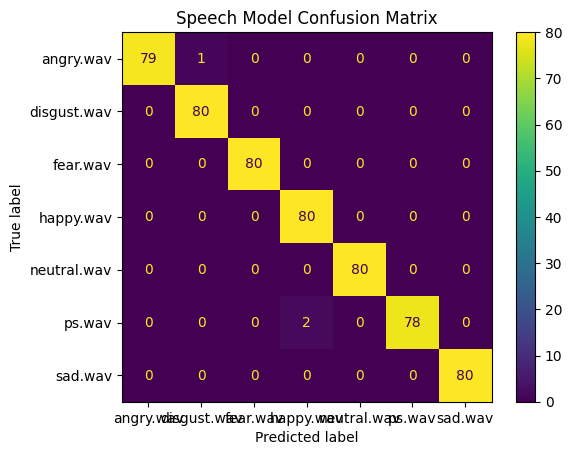

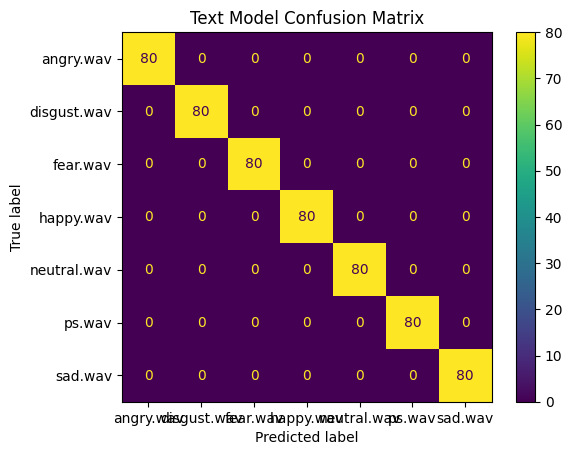

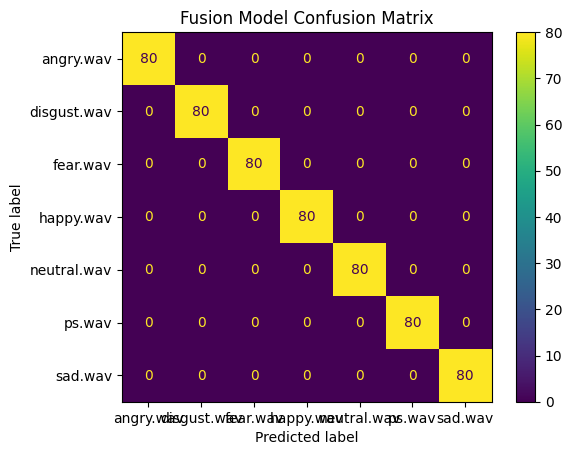

In [23]:


import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# predictions
y_pred_speech = np.argmax(
    speech_model.predict(X_test_s),
    axis=1
)

y_pred_text = np.argmax(
    text_model.predict(X_test_t),
    axis=1
)

y_pred_fusion = np.argmax(
    fusion_model.predict([X_test_s, X_test_t]),
    axis=1
)


# Confusion Matrices
cm_speech = confusion_matrix(y_test, y_pred_speech)
cm_text = confusion_matrix(y_test, y_pred_text)
cm_fusion = confusion_matrix(y_test, y_pred_fusion)


# Plot function
def plot_cm(cm, title):

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=le.classes_
    )

    disp.plot()
    plt.title(title)
    plt.show()


# Plot all
plot_cm(cm_speech, "Speech Model Confusion Matrix")
plot_cm(cm_text, "Text Model Confusion Matrix")
plot_cm(cm_fusion, "Fusion Model Confusion Matrix")


# Training curves

Speech history not available
Text history not available


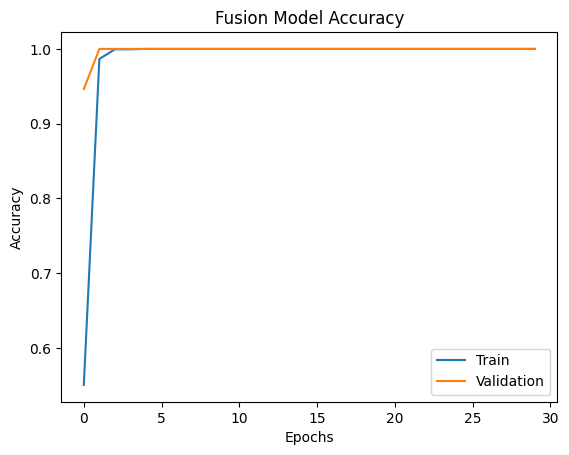

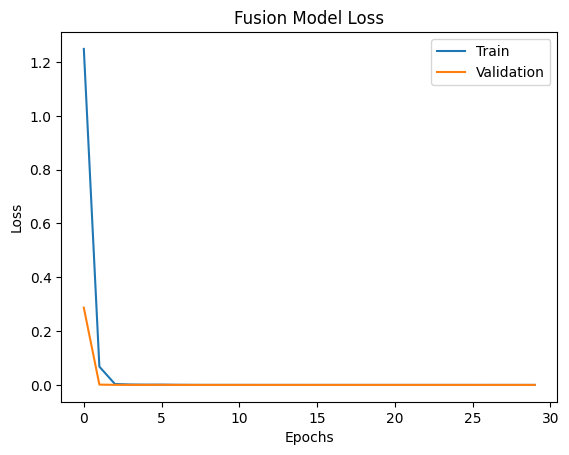

In [25]:
# ===============================
# TRAINING CURVES (FIXED)
# ===============================

import matplotlib.pyplot as plt


def plot_history_safe(hist, title):

    if hist is None:
        print(f"No history found for {title}")
        return

    # Accuracy
    plt.figure()
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(title + " Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Validation"])
    plt.show()

    # Loss
    plt.figure()
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title(title + " Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train", "Validation"])
    plt.show()


# Try available histories
try:
    plot_history_safe(history_speech, "Speech Model")
except:
    print("Speech history not available")

try:
    plot_history_safe(history_text, "Text Model")
except:
    print("Text history not available")

try:
    plot_history_safe(history_fusion, "Fusion Model")
except:
    print("Fusion history not available")
